# Temporal unet


In [1]:
import debugpy
import gc
from transformers import CLIPImageProcessor, CLIPTextModel, CLIPTokenizer, CLIPVisionModelWithProjection
from typing import Optional, Tuple, Union
from dataclasses import dataclass
import torch
import torch.nn as nn
from torch.nn import functional as F
from diffusers.models.unets import UNetSpatioTemporalConditionModel
from diffusers import StableVideoDiffusionPipeline
from diffusers.utils import load_image, export_to_video
from diffusers.utils.torch_utils import is_compiled_module, randn_tensor
import torch
import torch.nn as nn
from diffusers.configuration_utils import ConfigMixin, register_to_config
from diffusers.loaders import UNet2DConditionLoadersMixin
from diffusers.utils import BaseOutput, logging
from diffusers.models.attention_processor import CROSS_ATTENTION_PROCESSORS, AttentionProcessor, AttnProcessor
from diffusers.models.embeddings import TimestepEmbedding, Timesteps
from diffusers.models.modeling_utils import ModelMixin
from diffusers.models.unets.unet_3d_blocks import UNetMidBlockSpatioTemporal, get_down_block, get_up_block
from diffusers.models.unets import UNetSpatioTemporalConditionModel


from types import MethodType
torch.cuda.empty_cache()

/home/wisley/miniconda3/envs/wsl_diffusers/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/wisley/miniconda3/envs/wsl_diffusers/lib/python3.9/site-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


# Testing and printing

In [2]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float16
time =  torch.tensor(1).to(dtype=dtype)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logger = logging.get_logger(__name__)  # pylint: disable=invalid-name
from typing import Optional, List

from diffusers.pipelines.stable_video_diffusion.pipeline_stable_video_diffusion_with_controlnet import StableVideoDiffusionPipelineWithControlNet,SpatioTemporalControlNet, CustomConditioningNet, SpatioTemporalControlNetOutput

import gc
from diffusers import DiffusionPipeline

# Importing the pipelines
pipe = StableVideoDiffusionPipeline.from_pretrained(
    "stabilityai/stable-video-diffusion-img2vid", torch_dtype=torch.float16, variant="fp16"
)


#  `stable-video-diffusion-img2vid-xt`
pipeline = DiffusionPipeline.from_pretrained("stabilityai/stable-diffusion-2")

testing_unet = pipeline.unet
testing_unet = testing_unet.to(dtype=dtype, device=device)

# Getting the models
tokenizer = pipeline.tokenizer
text_encoder = pipeline.text_encoder
unet_weights = pipe.unet.state_dict()
my_unet = UNetSpatioTemporalConditionModel()
my_unet.load_state_dict(unet_weights)

def encode_prompt(
    prompt,
    device,
    do_classifier_free_guidance,
    negative_prompt="Simulation, artifacts, blurry, low resolution, low quality, noisy, grainy, distorted",
    num_images_per_prompt = 1,
    prompt_embeds: Optional[torch.FloatTensor] = None,
    negative_prompt_embeds: Optional[torch.FloatTensor] = None,
    lora_scale: Optional[float] = None,
    clip_skip: Optional[int] = None,
    text_encoder = None, 
    tokenizer = None):
    # Set the text_encoder and the tokenizer on the correct device  
    text_encoder = text_encoder.to(device)


    if prompt is not None and isinstance(prompt, str):
        batch_size = 1
    elif prompt is not None and isinstance(prompt, list):
        batch_size = len(prompt)
    else:
        batch_size = prompt_embeds.shape[0]

    if True:

        text_inputs = tokenizer(
            prompt,
            padding="max_length",
            max_length=tokenizer.model_max_length,
            truncation=True,
            return_tensors="pt",
        )
        text_input_ids = text_inputs.input_ids
        untruncated_ids = tokenizer(prompt, padding="longest", return_tensors="pt").input_ids

        if untruncated_ids.shape[-1] >= text_input_ids.shape[-1] and not torch.equal(
            text_input_ids, untruncated_ids
        ):
            removed_text = tokenizer.batch_decode(
                untruncated_ids[:, tokenizer.model_max_length - 1 : -1]
            )
            logger.warning(
                "The following part of your input was truncated because CLIP can only handle sequences up to"
                f" {tokenizer.model_max_length} tokens: {removed_text}"
            )

        if hasattr(text_encoder.config, "use_attention_mask") and text_encoder.config.use_attention_mask:
            attention_mask = text_inputs.attention_mask.to(device)
        else:
            attention_mask = None


        prompt_embeds = text_encoder(text_input_ids.to(device), attention_mask=attention_mask)
        prompt_embeds = prompt_embeds[0]
       

    if text_encoder is not None:
        prompt_embeds_dtype = text_encoder.dtype


    prompt_embeds = prompt_embeds.to(dtype=prompt_embeds_dtype, device=device)


    bs_embed, seq_len, _ = prompt_embeds.shape
    print(f"Shape of prompt embeds: {prompt_embeds.shape} {bs_embed} {seq_len}")
    
    # duplicate text embeddings for each generation per prompt, using mps friendly method
    prompt_embeds = prompt_embeds.repeat(1, num_images_per_prompt, 1)
    prompt_embeds = prompt_embeds.view(bs_embed * num_images_per_prompt, seq_len, -1)

    # get unconditional embeddings for classifier free guidance
    if do_classifier_free_guidance and negative_prompt_embeds is None:
        uncond_tokens: List[str]
        if negative_prompt is None:
            uncond_tokens = [""] * batch_size
        elif prompt is not None and type(prompt) is not type(negative_prompt):
            raise TypeError(
                f"`negative_prompt` should be the same type to `prompt`, but got {type(negative_prompt)} !="
                f" {type(prompt)}."
            )
        elif isinstance(negative_prompt, str):
            uncond_tokens = [negative_prompt]
        elif batch_size != len(negative_prompt):
            raise ValueError(
                f"`negative_prompt`: {negative_prompt} has batch size {len(negative_prompt)}, but `prompt`:"
                f" {prompt} has batch size {batch_size}. Please make sure that passed `negative_prompt` matches"
                " the batch size of `prompt`."
            )
        else:
            uncond_tokens = negative_prompt
        
        max_length = prompt_embeds.shape[1]
        uncond_input = tokenizer(
            uncond_tokens,
            padding="max_length",
            max_length=max_length,
            truncation=True,
            return_tensors="pt",
        )

        if hasattr(text_encoder.config, "use_attention_mask") and text_encoder.config.use_attention_mask:
            attention_mask = uncond_input.attention_mask.to(device)
        else:
            attention_mask = None

        negative_prompt_embeds = text_encoder(
            uncond_input.input_ids.to(device),
            attention_mask=attention_mask,
        )
        negative_prompt_embeds = negative_prompt_embeds[0]

    if do_classifier_free_guidance:
        # duplicate unconditional embeddings for each generation per prompt, using mps friendly method
        seq_len = negative_prompt_embeds.shape[1]

        negative_prompt_embeds = negative_prompt_embeds.to(dtype=prompt_embeds_dtype, device=device)

        negative_prompt_embeds = negative_prompt_embeds.repeat(1, num_images_per_prompt, 1)
        negative_prompt_embeds = negative_prompt_embeds.view(batch_size * num_images_per_prompt, seq_len, -1)


    
    embeds = torch.cat([prompt_embeds, negative_prompt_embeds])
    embeds = embeds.mean(dim=1, keepdim=True)

    return embeds

prompt = "A f a cat"
prompt_embeds = encode_prompt(prompt=prompt, device=device, do_classifier_free_guidance=True, text_encoder=text_encoder, tokenizer=tokenizer)

def get_add_time_ids(
  fps = 7,
  motion_bucket_id = 127,
  noise_aug_strength = 0.02,
  dtype = torch.float32,
  batch_size = 1,
  num_videos_per_prompt = 1,
  do_classifier_free_guidance = True,
):
  add_time_ids = [fps, motion_bucket_id, noise_aug_strength]

  add_time_ids = torch.tensor([add_time_ids], dtype=dtype)
  add_time_ids = add_time_ids.repeat(batch_size * num_videos_per_prompt, 1)

  if do_classifier_free_guidance:
      add_time_ids = torch.cat([add_time_ids, add_time_ids])

  return add_time_ids

added_time_ids = get_add_time_ids(dtype=dtype).to(device)

from diffusers.utils.import_utils import is_xformers_available
from packaging import version

testing_unet = testing_unet.to(dtype=dtype, device=device)
my_unet = my_unet.to(dtype=dtype, device=device)
# move time to divice
time = time.to(device)
print(f"Time is on: {time.device}")
from xformers.ops import MemoryEfficientAttentionFlashAttentionOp
# if True:
#     if is_xformers_available():
#         import xformers

#         xformers_version = version.parse(xformers.__version__)
#         if xformers_version == version.parse("0.0.16"):
#             pass

#         testing_unet.enable_xformers_memory_efficient_attention()
#     else:
#         raise ValueError("xformers is not available. Make sure it is installed correctly")
sample = torch.ones(2,14, 8, 36, 64)
# sample = torch.ones(2, 4, 64, 64)
sample = sample.to(dtype=dtype, device=device) 
time = time.to(dtype=dtype, device=device)
added_time_ids = added_time_ids.to(dtype=dtype, device=device)  
prompt_embeds = prompt_embeds.to(dtype=dtype, device=device)

for p in my_unet.parameters():
    p.requires_grad = False


noise_pred = my_unet.forward(
    sample,
    time,
    added_time_ids=added_time_ids.to(dtype=dtype, device=device),
    encoder_hidden_states = prompt_embeds.to(dtype=dtype, device=device),
    # encoder_hidden_states = None,
    return_dict=True,
    # controlnet_condition = torch.ones(25, 4, 576, 1024).to(dtype=dtype, device=device)
)    


# Print the sizes of the tensors

if noise_pred is not None:
    del noise_pred


Loading pipeline components...: 100%|██████████| 6/6 [00:00<00:00, 14.03it/s]


Shape of prompt embeds: torch.Size([1, 77, 1024]) 1 77
Time is on: cuda:0
AAAAAAAAAAAAAAAAAA Encoder hidden states shape: torch.Size([28, 1, 1024])
AAAAAAAAAAAAAAAAAA Sample shape: torch.Size([28, 320, 36, 64])


# Controlnet Initialization

In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import json


class DiffusionDataset(Dataset):
    def __init__(self, json_path):
        with open(json_path, 'r') as f:
            self.data = json.load(f)
        self.transform = transforms.Compose([
            transforms.Resize((576, 1024)),
            transforms.CenterCrop((576, 1024)),
        ])

    def __len__(self):
        # Assuming each set of ground truths represents a separate sample
        return len(self.data['ground_truth'])

    def __getitem__(self, idx):
        # Processing ground truth images
        to_tensor = transforms.ToTensor()
        ground_truth_images = [to_tensor(self.transform(Image.open(path))) for path in self.data['ground_truth'][idx]]

        # Processing conditioning images set one (assuming RGB, 4 channels after conversion)
        conditioning_images_one = [to_tensor(self.transform(Image.open(path))) for path in self.data['conditioning_images_one'][idx]]

        # Processing conditioning images set two (assuming grayscale, converted to RGB to match dimensions)
        conditioning_images_two = [to_tensor(self.transform(Image.open(path))) for path in self.data['conditioning_images_two'][idx]]
        
        # Concatenating condition one and two images along the channel dimension
        conditioned_images = [torch.cat((img_one, img_two), dim=0) for img_one, img_two in zip(conditioning_images_one, conditioning_images_two)]

        # Processing reference images (single per scene, matched by index)
        reference_image = self.transform(Image.open(self.data['reference_image'][idx][0]))

        # Retrieving the corresponding caption
        caption = self.data['caption'][idx][0]

        

        return {
            "ground_truth": torch.stack(ground_truth_images),
            "conditioning": torch.stack(conditioned_images),
            "caption": caption,
            "reference_image": reference_image
        }

def collate_fn(batch):
    ground_truth = torch.stack([item['ground_truth'] for item in batch])
    conditioning = torch.stack([item['conditioning'] for item in batch])
    captions = [item['caption'] for item in batch]  # List of strings, no need to stack
    reference_images = [item['reference_image'] for item in batch]
    

    return {
        "ground_truth": ground_truth.flatten(0, 1),
        "conditioning": conditioning.flatten(0, 1),
        "caption": captions[0],
        "reference_image": reference_images[0],
    }



train_dataset = DiffusionDataset(json_path='/mnt/e/13_Jasper_diffused_samples/complete_data_paths.json')

train_dataloader = DataLoader(
    train_dataset,
    shuffle=False,
    collate_fn=collate_fn,
    batch_size=1,  # Or your preferred batch size
    num_workers=0,  # Adjust based on your setup
)

for i, batch in enumerate(train_dataloader):
    to_tensor = transforms.ToTensor()
    print(f"Batch {i} has {batch['ground_truth'].shape[0]} samples")
    print(f"Caption: {batch['caption']}")
    print(f"Reference image shape: {to_tensor(batch['reference_image']).shape}")
    print(f"Conditioning image shape: {batch['conditioning'].shape}")

    if i == 0:
        break

Batch 0 has 14 samples
Caption: A driving scene during the day, with clear weather in singapore-onenorth
Reference image shape: torch.Size([3, 576, 1024])
Conditioning image shape: torch.Size([14, 4, 576, 1024])


In [3]:
# initialize the contrl net from my_net

from diffusers.pipelines.stable_video_diffusion.pipeline_stable_video_diffusion_with_controlnet import StableVideoDiffusionPipelineWithControlNet,SpatioTemporalControlNet, CustomConditioningNet, SpatioTemporalControlNetOutput

import gc
from diffusers import DiffusionPipeline

# Importing the pipelines
pipe = StableVideoDiffusionPipeline.from_pretrained(
    "stabilityai/stable-video-diffusion-img2vid", torch_dtype=torch.float16, variant="fp16"
)
pipeline = DiffusionPipeline.from_pretrained("stabilityai/stable-diffusion-2")


# Getting the models
tokenizer = pipeline.tokenizer
text_encoder = pipeline.text_encoder
unet_weights = pipe.unet.state_dict()
testing_unet = UNetSpatioTemporalConditionModel()
testing_unet.load_state_dict(unet_weights)
control_net_blank = SpatioTemporalControlNet.from_unet(testing_unet).half()
testing_unet = testing_unet.half()

Loading pipeline components...: 100%|██████████| 6/6 [00:00<00:00, 10.09it/s]


In [4]:
import torch
checkpoint = torch.load('/mnt/e/13_Jasper_diffused_samples/training/unet_with_scaling/test/model_checkpoint_5599.ckpt')


from diffusers.pipelines.stable_video_diffusion.pipeline_stable_video_diffusion_with_controlnet import StableVideoDiffusionPipelineWithControlNet,SpatioTemporalControlNet, CustomConditioningNet, SpatioTemporalControlNetOutput
control_net_trained = SpatioTemporalControlNet()
unet_trained = UNetSpatioTemporalConditionModel()
print(checkpoint['model_state_dict'].keys())     
control_net_trained.load_state_dict(checkpoint['model_state_dict'])
unet_trained.load_state_dict(checkpoint['unet_state_dict'])
control_net_trained = control_net_trained.half()
unet_trained = unet_trained.half()

odict_keys(['conv_in.weight', 'conv_in.bias', 'controlnet_down_blocks.0.weight', 'controlnet_down_blocks.0.bias', 'controlnet_down_blocks.1.weight', 'controlnet_down_blocks.1.bias', 'controlnet_down_blocks.2.weight', 'controlnet_down_blocks.2.bias', 'controlnet_down_blocks.3.weight', 'controlnet_down_blocks.3.bias', 'controlnet_down_blocks.4.weight', 'controlnet_down_blocks.4.bias', 'controlnet_down_blocks.5.weight', 'controlnet_down_blocks.5.bias', 'controlnet_down_blocks.6.weight', 'controlnet_down_blocks.6.bias', 'controlnet_down_blocks.7.weight', 'controlnet_down_blocks.7.bias', 'controlnet_down_blocks.8.weight', 'controlnet_down_blocks.8.bias', 'controlnet_down_blocks.9.weight', 'controlnet_down_blocks.9.bias', 'controlnet_down_blocks.10.weight', 'controlnet_down_blocks.10.bias', 'controlnet_down_blocks.11.weight', 'controlnet_down_blocks.11.bias', 'time_embedding.linear_1.weight', 'time_embedding.linear_1.bias', 'time_embedding.linear_2.weight', 'time_embedding.linear_2.bias', 'a

# Printing

In [ ]:
# Assuming model1 and model2 are your neural network models in TensorFlow
model1_state_dict  = control_net_blank.state_dict()
model2_state_dict  = control_net_trained.state_dict()

are_same = True
for p1, p2 in zip(model1_state_dict.values(), model2_state_dict.values()):
    if not torch.equal(p1, p2):
        are_same = False
        print(p1,p2)
        break

if are_same:
    print("The models have the same weights.")
else:
    print("The models do not have the same weights.")

tensor([[-0.0292,  0.0292, -0.0232,  ...,  0.0070,  0.0068, -0.0293],
        [ 0.0126, -0.0143,  0.0074,  ..., -0.0103,  0.0351, -0.0125],
        [ 0.0272, -0.0305, -0.0247,  ..., -0.0238, -0.0183, -0.0316],
        ...,
        [-0.0057, -0.0232,  0.0119,  ...,  0.0057,  0.0217, -0.0027],
        [ 0.0166, -0.0035, -0.0032,  ..., -0.0136,  0.0210, -0.0216],
        [ 0.0050, -0.0297,  0.0295,  ...,  0.0205, -0.0130, -0.0165]],
       dtype=torch.float16) tensor([[-1.8997e-02, -1.0264e-04,  3.2115e-04,  ...,  1.4046e-02,
          2.2751e-02, -2.8667e-03],
        [ 1.8875e-02, -2.8671e-02, -2.6703e-02,  ..., -3.2471e-02,
         -1.5228e-02,  3.1982e-02],
        [-1.3405e-02, -3.0869e-02, -2.0889e-02,  ...,  6.9962e-03,
          1.5945e-02, -1.3306e-02],
        ...,
        [-2.4368e-02,  3.7556e-03, -7.7665e-05,  ..., -3.4210e-02,
         -1.0155e-02,  5.1355e-04],
        [-8.4543e-04,  1.2459e-02,  7.4310e-03,  ..., -3.2074e-02,
          2.8763e-02,  9.1934e-03],
        [ 

In [10]:
def print_weights_sum(model):
    # Initialize a counter
    total_weight_sum = 0.0

    # Iterate over controlnet_down_blocks
    for i, block in enumerate(model.down_blocks):
        block_weight_sum = sum(p.data.sum() for p in block.parameters() if p.requires_grad)
        print(f"ControlNet Down Block {i} Weight Sum: {block_weight_sum}")
        total_weight_sum += block_weight_sum

    # Check the controlnet_mid_block
    mid_block_weight_sum = sum(p.data.sum() for p in model.controlnet_mid_block.parameters() if p.requires_grad)
    print(f"ControlNet Mid Block Weight Sum: {mid_block_weight_sum}")
    total_weight_sum += mid_block_weight_sum

    # Print total sum of weights for a sanity check
    print(f"Total Weight Sum of Specified Layers: {total_weight_sum}")


In [7]:
# Assuming `model` is your trained model instance
def print_sum_of_weights_for_zero_initialized_layers(model):
    layers_of_interest = [model.controlnet_mid_block] + list(model.controlnet_down_blocks)
    for i, layer in enumerate(layers_of_interest):
        if isinstance(layer, nn.Conv2d):
            weight_sum = layer.weight.sum().item()
            print(f"Layer {i} weight sum: {weight_sum}")
print_sum_of_weights_for_zero_initialized_layers(control_net_trained)
print_sum_of_weights_for_zero_initialized_layers(control_net_blank)

Layer 0 weight sum: 0.0166015625
Layer 1 weight sum: -0.01247406005859375
Layer 2 weight sum: 0.0170440673828125
Layer 3 weight sum: -0.0242156982421875
Layer 4 weight sum: -0.0230865478515625
Layer 5 weight sum: -0.001918792724609375
Layer 6 weight sum: 0.042938232421875
Layer 7 weight sum: -0.0821533203125
Layer 8 weight sum: 0.024871826171875
Layer 9 weight sum: -0.0256805419921875
Layer 10 weight sum: -0.171142578125
Layer 11 weight sum: -0.135009765625
Layer 12 weight sum: -0.67919921875
Layer 0 weight sum: 0.0
Layer 1 weight sum: 0.0
Layer 2 weight sum: 0.0
Layer 3 weight sum: 0.0
Layer 4 weight sum: 0.0
Layer 5 weight sum: 0.0
Layer 6 weight sum: 0.0
Layer 7 weight sum: 0.0
Layer 8 weight sum: 0.0
Layer 9 weight sum: 0.0
Layer 10 weight sum: 0.0
Layer 11 weight sum: 0.0
Layer 12 weight sum: 0.0


In [11]:
print_weights_sum(control_net_trained)
print_weights_sum(control_net_blank)
# print_weights_sum()


ControlNet Down Block 0 Weight Sum: -198.125
ControlNet Down Block 1 Weight Sum: 4816.0
ControlNet Down Block 2 Weight Sum: -3540.0
ControlNet Down Block 3 Weight Sum: 212.0
ControlNet Mid Block Weight Sum: 0.018035888671875
Total Weight Sum of Specified Layers: 1288.0
ControlNet Down Block 0 Weight Sum: -196.875
ControlNet Down Block 1 Weight Sum: 4816.0
ControlNet Down Block 2 Weight Sum: -3540.0
ControlNet Down Block 3 Weight Sum: 212.0
ControlNet Mid Block Weight Sum: 0.0
Total Weight Sum of Specified Layers: 1292.0


# Pipeline init

In [5]:
pipe_with_controlnet = StableVideoDiffusionPipelineWithControlNet(
    vae = pipe.vae,
    image_encoder = pipe.image_encoder,
    unet=unet_trained,
    scheduler=pipe.scheduler,
    feature_extractor=pipe.feature_extractor,
    controlnet=control_net_trained,
    tokenizer = tokenizer,
    text_encoder = text_encoder
)
pipe_with_controlnet.enable_model_cpu_offload()

In [6]:
prompt = "A driving scene during the night, with rainy weather in boston-seaport"
# prompt = batch['caption']
pseudo_sample = batch['conditioning'][:14]
# Define a simple torch generator
generator = torch.Generator().manual_seed(42)
image = batch['reference_image']

frames = pipe_with_controlnet( image = image,num_frames = 14, prompt=prompt, conditioning_image = pseudo_sample,  decode_chunk_size=8, generator=generator).frames[0]
# frames = pipe( image = image,num_frames = 14,    decode_chunk_size=8, generator=generator).frames[0]


these are the height and width of the latent: 576 and 1024  


  0%|          | 0/25 [00:00<?, ?it/s]

are we doing the classifier free guidance: True
tensor(0., device='cuda:0', dtype=torch.float16)


  4%|▍         | 1/25 [00:02<00:48,  2.00s/it]

are we doing the classifier free guidance: True
tensor(0., device='cuda:0', dtype=torch.float16)


  8%|▊         | 2/25 [00:02<00:26,  1.16s/it]

are we doing the classifier free guidance: True
tensor(0., device='cuda:0', dtype=torch.float16)


 12%|█▏        | 3/25 [00:03<00:19,  1.12it/s]

are we doing the classifier free guidance: True
tensor(0., device='cuda:0', dtype=torch.float16)


 16%|█▌        | 4/25 [00:03<00:16,  1.30it/s]

are we doing the classifier free guidance: True
tensor(0., device='cuda:0', dtype=torch.float16)


 20%|██        | 5/25 [00:04<00:14,  1.43it/s]

are we doing the classifier free guidance: True
tensor(0., device='cuda:0', dtype=torch.float16)


 24%|██▍       | 6/25 [00:04<00:12,  1.51it/s]

are we doing the classifier free guidance: True
tensor(0., device='cuda:0', dtype=torch.float16)


 28%|██▊       | 7/25 [00:05<00:11,  1.57it/s]

are we doing the classifier free guidance: True
tensor(0., device='cuda:0', dtype=torch.float16)


 32%|███▏      | 8/25 [00:06<00:10,  1.62it/s]

are we doing the classifier free guidance: True
tensor(0., device='cuda:0', dtype=torch.float16)


 36%|███▌      | 9/25 [00:06<00:09,  1.65it/s]

are we doing the classifier free guidance: True
tensor(0., device='cuda:0', dtype=torch.float16)


 40%|████      | 10/25 [00:07<00:08,  1.67it/s]

are we doing the classifier free guidance: True
tensor(0., device='cuda:0', dtype=torch.float16)


 44%|████▍     | 11/25 [00:07<00:08,  1.69it/s]

are we doing the classifier free guidance: True
tensor(0., device='cuda:0', dtype=torch.float16)


 48%|████▊     | 12/25 [00:08<00:07,  1.71it/s]

are we doing the classifier free guidance: True
tensor(0., device='cuda:0', dtype=torch.float16)


 52%|█████▏    | 13/25 [00:08<00:07,  1.71it/s]

are we doing the classifier free guidance: True
tensor(0., device='cuda:0', dtype=torch.float16)


 56%|█████▌    | 14/25 [00:09<00:06,  1.72it/s]

are we doing the classifier free guidance: True
tensor(0., device='cuda:0', dtype=torch.float16)


 60%|██████    | 15/25 [00:10<00:05,  1.72it/s]

are we doing the classifier free guidance: True
tensor(0., device='cuda:0', dtype=torch.float16)


 64%|██████▍   | 16/25 [00:10<00:05,  1.73it/s]

are we doing the classifier free guidance: True
tensor(0., device='cuda:0', dtype=torch.float16)


 68%|██████▊   | 17/25 [00:11<00:04,  1.72it/s]

are we doing the classifier free guidance: True
tensor(0., device='cuda:0', dtype=torch.float16)


 72%|███████▏  | 18/25 [00:11<00:04,  1.73it/s]

are we doing the classifier free guidance: True
tensor(0., device='cuda:0', dtype=torch.float16)


 76%|███████▌  | 19/25 [00:12<00:03,  1.72it/s]

are we doing the classifier free guidance: True
tensor(0., device='cuda:0', dtype=torch.float16)


 80%|████████  | 20/25 [00:13<00:02,  1.72it/s]

are we doing the classifier free guidance: True
tensor(0., device='cuda:0', dtype=torch.float16)


 84%|████████▍ | 21/25 [00:13<00:02,  1.72it/s]

are we doing the classifier free guidance: True
tensor(0., device='cuda:0', dtype=torch.float16)


 88%|████████▊ | 22/25 [00:14<00:01,  1.72it/s]

are we doing the classifier free guidance: True
tensor(0., device='cuda:0', dtype=torch.float16)


 92%|█████████▏| 23/25 [00:14<00:01,  1.72it/s]

are we doing the classifier free guidance: True
tensor(0., device='cuda:0', dtype=torch.float16)


 96%|█████████▌| 24/25 [00:15<00:00,  1.72it/s]

are we doing the classifier free guidance: True
tensor(0., device='cuda:0', dtype=torch.float16)


100%|██████████| 25/25 [00:15<00:00,  1.57it/s]


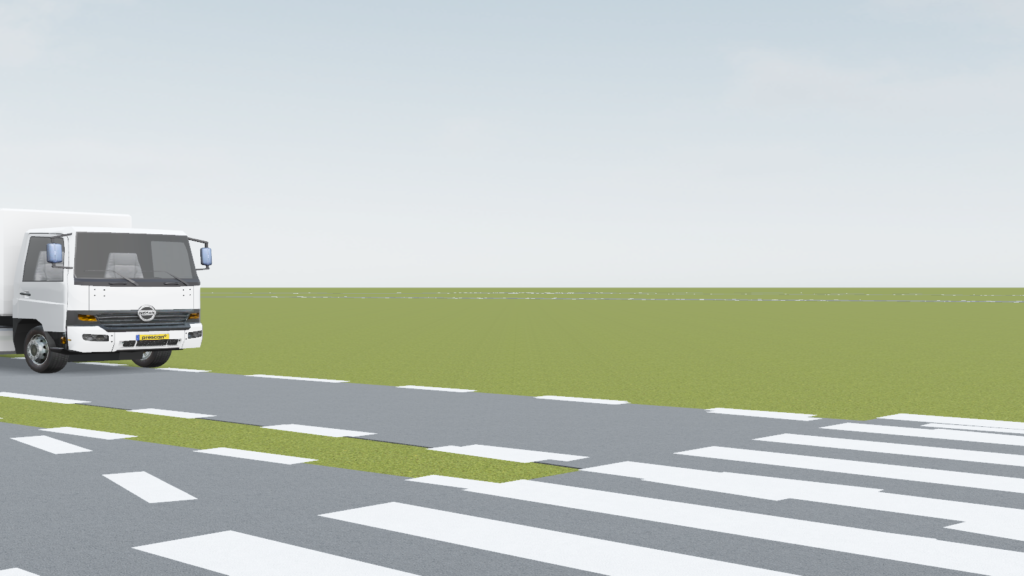

In [7]:
image = batch['reference_image']
image.show()

In [ ]:

from torchvision import transforms
to_tensor = to_tensor = transforms.ToTensor()
image = to_tensor(image)
print(f'this is the shape of the image {image.shape}')

this is the shape of the image torch.Size([3, 360, 640])


In [ ]:
def _encode_vae_image(

        image: torch.Tensor,
        vae
    ):

        with torch.no_grad(): 

            # print(f"this is the shape of the image: {image.shape}")
            image = image.to(device=vae.device, dtype=vae.dtype)
            image_latents = vae.encode(image.to(device=vae.device)).latent_dist.mode()



            # duplicate image_latents for each generation per prompt, using mps friendly method
            image_latents = image_latents.repeat(1, 1, 1, 1)

            return image_latents

def encode_batch(images, vae ):
    outputs = []  # Initialize an empty list to store each output


    # Loop through each image in the pseudo_image tensor
    for i in range(images.shape[0]):
        output = _encode_vae_image(
            images[i].unsqueeze(0),  # Unsqueeze to add the batch dimension back
            vae=vae
        )
        outputs.append(output)  # Append the output to the list

    # Concatenate all outputs along the 0 dimension
    final_output = torch.cat(outputs, dim=0)
    final_output = final_output.unsqueeze(0)

    if True:
        negative_image_latents = torch.zeros_like(final_output)

        # For classifier free guidance, we need to do two forward passes.
        # Here we concatenate the unconditional and text embeddings into a single batch
        # to avoid doing two forward passes
        final_output = torch.cat([negative_image_latents, final_output])

    return final_output

output = encode_batch(batch['ground_truth'], pipe_with_controlnet.vae)
print(f"Output shape: {output.shape}")

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument weight in method wrapper_CUDA___slow_conv2d_forward)

In [8]:
export_to_video(frames, "wrong_pipeline.mp4", fps=7)

'wrong_pipeline.mp4'

# Run the models


In [12]:
torch.cuda.empty_cache()
def prepare_latents(
    batch_size,
    num_frames,
    num_channels_latents,
    height,
    width,
    dtype,
    device,
    generator,
    latents=None,
):
    shape = (
        batch_size,
        num_frames,
        num_channels_latents // 2,
        height // 1,
        width // 1,
    )
    if isinstance(generator, list) and len(generator) != batch_size:
        raise ValueError(
            f"You have passed a list of generators of length {len(generator)}, but requested an effective batch"
            f" size of {batch_size}. Make sure the batch size matches the length of the generators."
        )

    if latents is None:
        latents = randn_tensor(shape, generator=generator, device=device, dtype=dtype)
    else:
        latents = latents.to(device)

    # scale the initial noise by the standard deviation required by the scheduler
    latents = latents * 0.2
    return latents

def pseudo_image_embeddings( shape, generator, device, dtype, do_classifier_free_guidance = True ):
    image_embeddings = randn_tensor(shape, generator=generator, device= device, dtype=dtype)

    if do_classifier_free_guidance:
        negative_image_embeddings = torch.zeros_like(image_embeddings)

        # For classifier free guidance, we need to do two forward passes.
        # Here we concatenate the unconditional and text embeddings into a single batch
        # to avoid doing two forward passes
        return torch.cat([negative_image_embeddings, image_embeddings])

def get_add_time_ids(
  fps = 7,
  motion_bucket_id = 127,
  noise_aug_strength = 0.02,
  dtype = torch.float32,
  batch_size = 1,
  num_videos_per_prompt = 1,
  do_classifier_free_guidance = True,
):
  add_time_ids = [fps, motion_bucket_id, noise_aug_strength]

  add_time_ids = torch.tensor([add_time_ids], dtype=dtype)
  add_time_ids = add_time_ids.repeat(batch_size * num_videos_per_prompt, 1)

  if do_classifier_free_guidance:
      add_time_ids = torch.cat([add_time_ids, add_time_ids])

  return add_time_ids

dtype = torch.float32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

generator = torch.Generator().manual_seed(42)  # For reproducibility

# Generate original latents with specified dtype
my_latents = prepare_latents(1, 1, 8, 64, 64, dtype, device, generator)

# Apply classifier-free guidance by duplicating the latents and ensuring the correct dtype
latent_model_input = torch.cat([my_latents] * 2)  # Inherits dtype from my_latents

# Create pseudo image latents by cloning the original latents
pseudo_image_latents = latent_model_input.clone()  # Inherits dtype

# Concatenate pseudo image latents over the channels dimension, ensuring matching dtype
latent_model_input = torch.cat([latent_model_input, pseudo_image_latents], dim=2)


# Create the fake image embeddings with the specified dtype
hidden_image_embeddings = pseudo_image_embeddings((1, 1, 1024), generator, device, dtype)

added_time_ids = get_add_time_ids(dtype=dtype).to(device)

# Verify the dtype of both tensors
print(f"Latent model input dtype: {latent_model_input.dtype}")
print(f"Hidden image embeddings dtype: {hidden_image_embeddings.dtype}")

print(latent_model_input.shape)
print(hidden_image_embeddings.shape)
print(added_time_ids.shape)

# Print on which model they are
print(f"Latent model input is on: {latent_model_input.device}")
print(f"Hidden image embeddings are on: {hidden_image_embeddings.device}")
# Assuming added_time_ids is also a tensor; replace this with the actual tensor variable if different
print(f"Added time IDs are on: {added_time_ids.device}")

Latent model input dtype: torch.float32
Hidden image embeddings dtype: torch.float32
torch.Size([2, 1, 8, 64, 64])
torch.Size([2, 1, 1024])
torch.Size([2, 3])
Latent model input is on: cuda:0
Hidden image embeddings are on: cuda:0
Added time IDs are on: cuda:0


In [ ]:
with torch.no_grad():

    noise_pred = testing_unet.forward(
        latent_model_input.to(dtype=dtype),
        torch.tensor(1).to(dtype=dtype, device=device),
        encoder_hidden_states=hidden_image_embeddings.to(dtype=dtype),
        added_time_ids=added_time_ids.to(dtype=dtype),
        down_block_additional_residuals= None,
        mid_block_additional_residual = None,
        return_dict=False,
    )[0]

    print(noise_pred.shape)
    if noise_pred is not None:
        del noise_pred



RuntimeError: mat1 and mat2 must have the same dtype, but got Float and Half

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logger = logging.get_logger(__name__)  # pylint: disable=invalid-name
from typing import Optional, List

def encode_prompt(
    prompt,
    device,
    do_classifier_free_guidance,
    negative_prompt="Simulation, artifacts, blurry, low resolution, low quality, noisy, grainy, distorted",
    num_images_per_prompt = 1,
    prompt_embeds: Optional[torch.FloatTensor] = None,
    negative_prompt_embeds: Optional[torch.FloatTensor] = None,
    lora_scale: Optional[float] = None,
    clip_skip: Optional[int] = None,
    text_encoder = None, 
    tokenizer = None):
    # Set the text_encoder and the tokenizer on the correct device  
    text_encoder = text_encoder.to(device)


    if prompt is not None and isinstance(prompt, str):
        batch_size = 1
    elif prompt is not None and isinstance(prompt, list):
        batch_size = len(prompt)
    else:
        batch_size = prompt_embeds.shape[0]

    if True:

        text_inputs = tokenizer(
            prompt,
            padding="max_length",
            max_length=tokenizer.model_max_length,
            truncation=True,
            return_tensors="pt",
        )
        text_input_ids = text_inputs.input_ids
        untruncated_ids = tokenizer(prompt, padding="longest", return_tensors="pt").input_ids

        if untruncated_ids.shape[-1] >= text_input_ids.shape[-1] and not torch.equal(
            text_input_ids, untruncated_ids
        ):
            removed_text = tokenizer.batch_decode(
                untruncated_ids[:, tokenizer.model_max_length - 1 : -1]
            )
            logger.warning(
                "The following part of your input was truncated because CLIP can only handle sequences up to"
                f" {tokenizer.model_max_length} tokens: {removed_text}"
            )

        if hasattr(text_encoder.config, "use_attention_mask") and text_encoder.config.use_attention_mask:
            attention_mask = text_inputs.attention_mask.to(device)
        else:
            attention_mask = None


        prompt_embeds = text_encoder(text_input_ids.to(device), attention_mask=attention_mask)
        prompt_embeds = prompt_embeds[0]
       

    if text_encoder is not None:
        prompt_embeds_dtype = text_encoder.dtype


    prompt_embeds = prompt_embeds.to(dtype=prompt_embeds_dtype, device=device)


    bs_embed, seq_len, _ = prompt_embeds.shape
    print(f"Shape of prompt embeds: {prompt_embeds.shape} {bs_embed} {seq_len}")
    
    # duplicate text embeddings for each generation per prompt, using mps friendly method
    prompt_embeds = prompt_embeds.repeat(1, num_images_per_prompt, 1)
    prompt_embeds = prompt_embeds.view(bs_embed * num_images_per_prompt, seq_len, -1)

    # get unconditional embeddings for classifier free guidance
    if do_classifier_free_guidance and negative_prompt_embeds is None:
        uncond_tokens: List[str]
        if negative_prompt is None:
            uncond_tokens = [""] * batch_size
        elif prompt is not None and type(prompt) is not type(negative_prompt):
            raise TypeError(
                f"`negative_prompt` should be the same type to `prompt`, but got {type(negative_prompt)} !="
                f" {type(prompt)}."
            )
        elif isinstance(negative_prompt, str):
            uncond_tokens = [negative_prompt]
        elif batch_size != len(negative_prompt):
            raise ValueError(
                f"`negative_prompt`: {negative_prompt} has batch size {len(negative_prompt)}, but `prompt`:"
                f" {prompt} has batch size {batch_size}. Please make sure that passed `negative_prompt` matches"
                " the batch size of `prompt`."
            )
        else:
            uncond_tokens = negative_prompt
        
        max_length = prompt_embeds.shape[1]
        uncond_input = tokenizer(
            uncond_tokens,
            padding="max_length",
            max_length=max_length,
            truncation=True,
            return_tensors="pt",
        )

        if hasattr(text_encoder.config, "use_attention_mask") and text_encoder.config.use_attention_mask:
            attention_mask = uncond_input.attention_mask.to(device)
        else:
            attention_mask = None

        negative_prompt_embeds = text_encoder(
            uncond_input.input_ids.to(device),
            attention_mask=attention_mask,
        )
        negative_prompt_embeds = negative_prompt_embeds[0]

    if do_classifier_free_guidance:
        # duplicate unconditional embeddings for each generation per prompt, using mps friendly method
        seq_len = negative_prompt_embeds.shape[1]

        negative_prompt_embeds = negative_prompt_embeds.to(dtype=prompt_embeds_dtype, device=device)

        negative_prompt_embeds = negative_prompt_embeds.repeat(1, num_images_per_prompt, 1)
        negative_prompt_embeds = negative_prompt_embeds.view(batch_size * num_images_per_prompt, seq_len, -1)


    
    embeds = torch.cat([prompt_embeds, negative_prompt_embeds])
    embeds = embeds.mean(dim=1, keepdim=True)

    return embeds

prompt = "A f a cat"
prompt_embeds = encode_prompt(prompt=prompt, device=device, do_classifier_free_guidance=True, text_encoder=text_encoder, tokenizer=tokenizer)
print(prompt_embeds.shape)



Shape of prompt embeds: torch.Size([1, 77, 1024]) 1 77
torch.Size([2, 1, 1024])


In [ ]:
print(torch.cuda.is_available())

True


In [ ]:
# I have a sample of the following dimensions: sample = torch.ones(2,25, 8, 72, 128), because this sample is abit to big I would like to downsampel to the following dimernesions
sample = torch.ones(2,25, 8, 36, 64) please help

In [ ]:

import torch

# Define the original dimensions
original_dimensions = (2, 25, 8, 72, 128)

# Define the target dimensions
target_dimensions = (2, 25, 8, 36, 64)

# Create a sample tensor with the original dimensions
sample = torch.ones(original_dimensions)

# Downsample the sample tensor to the target dimensions using interpolation
downsampled_sample = torch.nn.functional.interpolate(sample, size=target_dimensions[2:] ,mode='nearest')

# Check the dimensions of the downsampled sample tensor
print(downsampled_sample.shape)

torch.Size([2, 25, 8, 36, 64])


In [18]:

dtype = torch.float16
testing_unet.requires_grad_(False)

for p in testing_unet.parameters():
    p.requires_grad = False


time =  torch.tensor(1).to(dtype=dtype, device=device)
if True:
    
    sample = torch.ones(2,14, 8, 36, 64).to(dtype=dtype, device=device)    

    # first resize to (50,8,72,128)
    # sample_control = sample.resize(50,8,72,128)
    # sample_downsampled = torch.nn.functional.interpolate(sample_control, scale_factor=0.5, mode='nearest')

    # movce back

    (down_block_res_samples, mid_block_res_samples) = control_net_blank.forward(
        sample.to(dtype=dtype),
        time,
        encoder_hidden_states=hidden_image_embeddings.to(dtype=dtype),
        added_time_ids=added_time_ids.to(dtype=dtype),
        return_dict=False,
    )

    # reverse the down_block_res_samples tuple
    # down_block_res_samples = down_block_res_samples[::-1]

    print(f"Length of down_block_res_samples afterprocesssing: {len(down_block_res_samples)}")


    noise_pred = testing_unet.forward(
        sample.to(dtype=dtype),
        torch.tensor(1).to(dtype=dtype, device=device),
        encoder_hidden_states=hidden_image_embeddings.to(dtype=dtype),
        # Maybe I need to reverse the order of the tensors
        down_block_additional_residuals= down_block_res_samples,
        mid_block_additional_residual = mid_block_res_samples,
        added_time_ids=added_time_ids.to(dtype=dtype),
        return_dict=False,
    )[0]

    # Print the sizes of the tensors
    if noise_pred is not None:
        del noise_pred


Length of down_block_res_samples afterprocesssing: 12


In [ ]:
conditioning_net = CustomConditioningNet()
pseudo_sample = torch.randn(25, 4, 578, 1028)
hoi = conditioning_net.forward(pseudo_sample)
print(hoi.shape)

torch.Size([2, 25, 320, 72, 128])
